# How many long-period TCEs were observed per channel?

In [1]:
%matplotlib inline
import matplotlib.pyplot as pl
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
import seaborn as sns

import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm

In [2]:
# Read the TCE table
tcedf = pd.read_csv('../data/q1_q17_dr25_tce.csv')
# Add the unique TCE ID used by the RoboVetter output:
tcedf.loc[:, 'tce'] = ['{:09d}-{:02d}'.format(row.kepid, row.tce_plnt_num) for row in tcedf.itertuples()]

In [17]:
long_period_tces = tcedf[tcedf.tce_period > 100]
len(long_period_tces)

12968

In [18]:
long_period_tces.head()

,ra,dec,tce_delivname,tce_datalink_dvr,tce_datalink_dvs,tce_nkoi,kepid,tce_plnt_num,tce_num_transits,tce_max_sngle_ev,...,tce_ptemp_stat,tce_cap_stat,tce_hap_stat,tce_rb_tpdur,tce_rb_tcount0,tce_rb_tcount1,tce_rb_tcount2,tce_rb_tcount3,tce_rb_tcount4,tce
0,291.701250,37.66675,q1_q17_dr25_tce,002/002304/002304168/dv/kplr002304168-20160209...,002/002304/002304168/dv/kplr002304168-002-2016...,0,2304168,2,4,9.305,...,0.0000,0.9458,0.8097,24,4,0,0,0,0,002304168-02
5,291.477371,37.62855,q1_q17_dr25_tce,002/002303/002303102/dv/kplr002303102-20160209...,002/002303/002303102/dv/kplr002303102-010-2016...,0,2303102,10,3,9.748,...,7.1010,2.6640,2.0380,31,2,0,0,0,0,002303102-10
11,291.063879,36.63581,q1_q17_dr25_tce,000/000892/000892376/dv/kplr000892376-20160209...,000/000892/000892376/dv/kplr000892376-001-2016...,0,892376,1,3,9.917,...,3.9710,2.1990,0.2353,24,3,0,0,0,0,000892376-01
14,291.063879,36.63581,q1_q17_dr25_tce,000/000892/000892376/dv/kplr000892376-20160209...,000/000892/000892376/dv/kplr000892376-004-2016...,0,892376,4,3,13.270,...,0.6546,3.3580,0.3712,6,3,0,0,0,0,000892376-04
16,291.063879,36.63581,q1_q17_dr25_tce,000/000892/000892376/dv/kplr000892376-20160209...,000/000892/000892376/dv/kplr000892376-005-2016...,0,892376,5,10,8.958,...,0.6064,1.1210,2.0770,24,9,0,0,0,0,000892376-05


In [26]:
import requests

QUARTER = 10

def get_channel_module_output(kepler_id):
    # Hack to prevent MAST from throwing a stupid 'Max retries exceeded with url' error
    max_records = np.random.randint(10000, 999990000)
    url = ('http://archive.stsci.edu/kepler/data_search/search.php?'
           'target={}&sci_data_quarter={}'
           '&action=Search&outputformat=JSON'
           '&max_records={}').format(int(kepler_id), int(QUARTER), max_records)
    resp = requests.get(url)
    if 'no rows found' in str(resp.content):
        return None, None, None
    else:
        return int(resp.json()[0]['Channel']), int(resp.json()[0]['Module']), int(resp.json()[0]['Output'])

def tce_to_channel_module_output(tce_idx):
    tce = long_period_tces.ix[tce_idx]
    ch, mod, out = get_channel_module_output(tce.kepid)
    return {'idx': tce_idx,
            'kepid': tce.kepid,
            'quarter': QUARTER,
            'channel': ch,
            'module': mod,
            'output': out}

In [27]:
import multiprocessing
pool = multiprocessing.Pool(processes=15)
results = []
for result in tqdm(pool.imap(tce_to_channel_module_output, long_period_tces.index),
                   total=len(long_period_tces), mininterval=120, maxinterval=240):
    results.append(result)



  0%|          | 0/12968 [00:00<?, ?it/s]

 13%|█▎        | 1712/12968 [02:00<13:09, 14.26it/s]

 28%|██▊       | 3574/12968 [04:00<10:43, 14.60it/s]

 40%|████      | 5232/12968 [06:00<08:59, 14.35it/s]

 54%|█████▍    | 7026/12968 [08:00<06:49, 14.52it/s]

 68%|██████▊   | 8769/12968 [10:00<04:49, 14.52it/s]

 81%|████████  | 10473/12968 [12:00<02:53, 14.42it/s]

 94%|█████████▍| 12198/12968 [14:01<00:53, 14.40it/s]

100%|██████████| 12968/12968 [14:59<00:00, 14.41it/s]

In [29]:
channelinfo = pd.DataFrame(results)
channelinfo.index = channelinfo['idx']
channelinfo.head()

,channel,idx,kepid,module,output,quarter
idx,,,,,,
0,4.0,0,2304168,2.0,4.0,10
5,4.0,5,2303102,2.0,4.0,10
11,4.0,11,892376,2.0,4.0,10
14,4.0,14,892376,2.0,4.0,10
16,4.0,16,892376,2.0,4.0,10


In [38]:
q10 = long_period_tces.merge(channelinfo, left_index=True, right_index=True)

In [39]:
print(len(q10))
q10.head()

12968


,ra,dec,tce_delivname,tce_datalink_dvr,tce_datalink_dvs,tce_nkoi,kepid_x,tce_plnt_num,tce_num_transits,tce_max_sngle_ev,...,tce_rb_tcount2,tce_rb_tcount3,tce_rb_tcount4,tce,channel,idx,kepid_y,module,output,quarter
0,291.701250,37.66675,q1_q17_dr25_tce,002/002304/002304168/dv/kplr002304168-20160209...,002/002304/002304168/dv/kplr002304168-002-2016...,0,2304168,2,4,9.305,...,0,0,0,002304168-02,4.0,0,2304168,2.0,4.0,10
5,291.477371,37.62855,q1_q17_dr25_tce,002/002303/002303102/dv/kplr002303102-20160209...,002/002303/002303102/dv/kplr002303102-010-2016...,0,2303102,10,3,9.748,...,0,0,0,002303102-10,4.0,5,2303102,2.0,4.0,10
11,291.063879,36.63581,q1_q17_dr25_tce,000/000892/000892376/dv/kplr000892376-20160209...,000/000892/000892376/dv/kplr000892376-001-2016...,0,892376,1,3,9.917,...,0,0,0,000892376-01,4.0,11,892376,2.0,4.0,10
14,291.063879,36.63581,q1_q17_dr25_tce,000/000892/000892376/dv/kplr000892376-20160209...,000/000892/000892376/dv/kplr000892376-004-2016...,0,892376,4,3,13.270,...,0,0,0,000892376-04,4.0,14,892376,2.0,4.0,10
16,291.063879,36.63581,q1_q17_dr25_tce,000/000892/000892376/dv/kplr000892376-20160209...,000/000892/000892376/dv/kplr000892376-005-2016...,0,892376,5,10,8.958,...,0,0,0,000892376-05,4.0,16,892376,2.0,4.0,10


12110


(array([ 181.,  188.,  239.,  168.,    0.,    0.,    0.,    0.,  201.,
         207.,  295.,  177.,   80.,  173.,  144.,   89.,  171.,  353.,
         212.,  140.,  223.,  189.,  168.,  176.,  210.,  633.,  181.,
         170.,  145.,  139.,  156.,  182.,   73.,   80.,  116.,   79.,
          94.,  139.,  168.,  136.,  263.,  108.,  257.,  263.,  185.,
         250.,  185.,  172.,  128.,  137.,  154.,   95.,   61.,  104.,
          54.,   74.,   98.,  232.,   86.,   70.,  138.,  100.,   88.,
         112.,  173.,  309.,  139.,  142.,  146.,  114.,  134.,  118.,
          72.,   80.,   58.,   68.,   78.,   47.,   95.,   70.,  106.,
          96.,   57.,  119.]),
 array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
         23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
         34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
         45.,  46.,  47.,  48.,  4

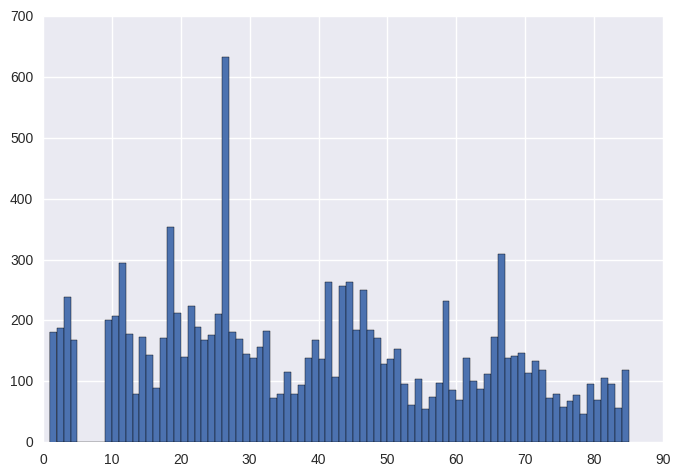

In [42]:
mask = ~q10.channel.isnull()
print(mask.sum())
pl.hist(q10.channel[mask], bins=84, range=(1, 85))

In [52]:
q10['ptransit'] = 1 / q10.tce_period

In [60]:
by_channel = q10.groupby(by='channel')
by_channel['ptransit'].mean()

channel
1.0     0.003475
2.0     0.003700
3.0     0.003838
4.0     0.003588
9.0     0.003833
10.0    0.003739
11.0    0.004028
12.0    0.003737
13.0    0.003457
14.0    0.003166
15.0    0.003452
16.0    0.003294
17.0    0.003243
18.0    0.002871
19.0    0.003109
20.0    0.003398
21.0    0.003988
22.0    0.003089
23.0    0.003617
24.0    0.003281
25.0    0.003462
26.0    0.002774
27.0    0.003704
28.0    0.004043
29.0    0.003843
30.0    0.003309
31.0    0.003987
32.0    0.003962
33.0    0.003377
34.0    0.003594
          ...   
55.0    0.003648
56.0    0.003172
57.0    0.003187
58.0    0.002638
59.0    0.003455
60.0    0.003085
61.0    0.003243
62.0    0.003318
63.0    0.003393
64.0    0.003704
65.0    0.003180
66.0    0.003032
67.0    0.003370
68.0    0.003038
69.0    0.003159
70.0    0.002988
71.0    0.003384
72.0    0.003900
73.0    0.003488
74.0    0.002757
75.0    0.003208
76.0    0.003913
77.0    0.003872
78.0    0.003987
79.0    0.003865
80.0    0.003279
81.0    0.003033
82.0  

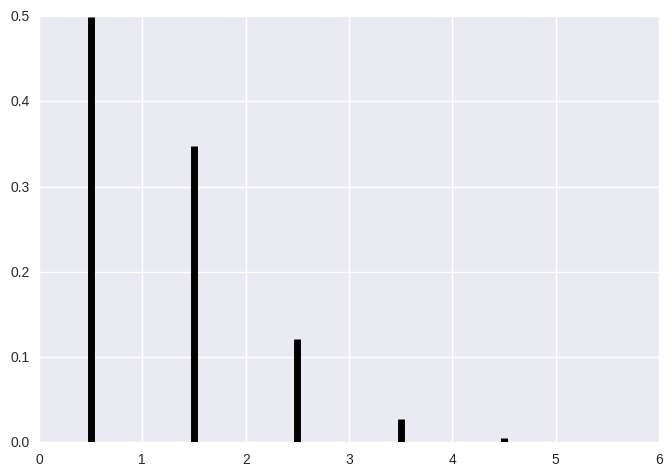

In [62]:
from scipy.stats import binom
n, p = 200, 0.003475
x = np.arange(0, 6)
pl.vlines(x + 0.5, 0, binom.pmf(x, n, p), lw=5, alpha=1, label='Binomial distribution')